Number of Classes: 102 (Fixed - Oxford-102 Flowers Dataset)
Training Samples: 1020


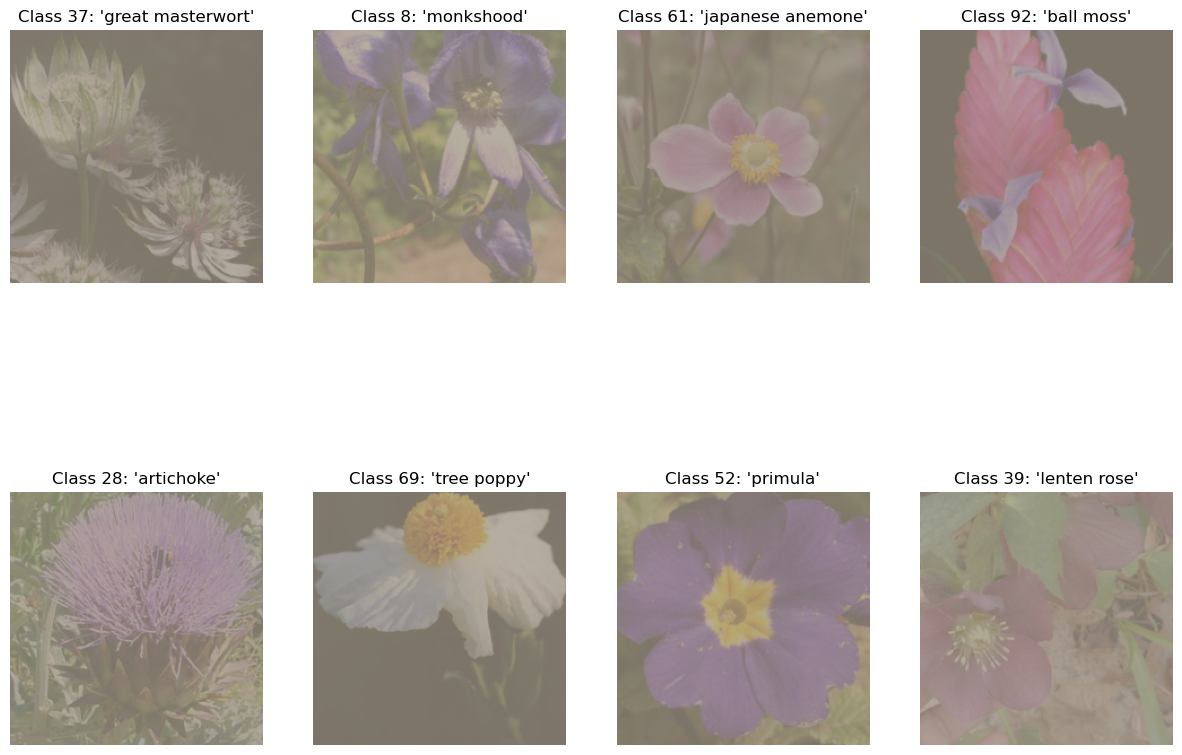

In [11]:
# Cell 1: Environment Setup
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Cell 2: Dataset Analysis
train_data = datasets.Flowers102(
    root='./data',
    split='train',
    transform=transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ]),
    download=True
)

# Corrected class information access
print(f"Number of Classes: 102 (Fixed - Oxford-102 Flowers Dataset)")  # Manual specification
print(f"Training Samples: {len(train_data)}")

# Cell 3: Visualization (Updated)
# Cell 3: Visualization


# Load class names (must have flower_classes.txt in same folder)
with open('flower_classes.txt') as f:
    class_names = [line.strip() for line in f]
assert len(class_names) == 102, "Need exactly 102 class names"

fig, axs = plt.subplots(2, 4, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5)
for ax in axs.flat:
    idx = np.random.randint(0, len(train_data))
    img, label = train_data[idx]
    
    # Denormalize image
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    # Handle label offset (Flowers102 uses 0-101 labels)
    ax.imshow(img)
    ax.set_title(f"Class {label}: {class_names[label]}")
    ax.axis('off')
plt.show()

In [13]:
# Cell 4: Model Training & Evaluation
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load test dataset
test_data = datasets.Flowers102(
    root='./data',
    split='test',
    transform=transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ]),
    download=True
)

print(f"Test Samples: {len(test_data)}")

# Create data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Define a simple CNN model
class FlowerCNN(nn.Module):
    def __init__(self, num_classes=102):
        super(FlowerCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64*56*56, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Initialize model, loss function, and optimizer
model = FlowerCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.numpy())
        all_preds.extend(preds.numpy())

# Generate accuracy report
print("\n" + "="*50)
print("Accuracy Report")
print("="*50)
print(f"Accuracy: {accuracy_score(all_labels, all_preds)*100:.2f}%")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))
print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

Test Samples: 6149
Epoch [1/10], Loss: 5.2488
Epoch [2/10], Loss: 4.6078
Epoch [3/10], Loss: 4.5060
Epoch [4/10], Loss: 4.3473
Epoch [5/10], Loss: 4.1601
Epoch [6/10], Loss: 3.8582
Epoch [7/10], Loss: 3.5695
Epoch [8/10], Loss: 3.2412
Epoch [9/10], Loss: 2.8099
Epoch [10/10], Loss: 2.3891

Accuracy Report
Accuracy: 9.16%

Classification Report:
                             precision    recall  f1-score   support

            'pink primrose'       0.00      0.00      0.00        20
'hard-leaved pocket orchid'       0.38      0.65      0.48        40
         'canterbury bells'       0.01      0.05      0.02        20
                'sweet pea'       0.20      0.17      0.18        36
         'english marigold'       0.00      0.00      0.00        45
               'tiger lily'       0.02      0.12      0.03        25
              'moon orchid'       0.06      0.05      0.05        20
         'bird of paradise'       0.20      0.12      0.15        65
                'monkshood'    

D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
